<a href="https://colab.research.google.com/github/kasparvonbeelen/lancaster-newspaper-workshop/blob/wc/LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q bitsandbytes sentencepiece accelerate transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 34.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer, BitsAndBytesConfig
from tqdm import tqdm
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')
device = 'cuda'

In [ ]:
df = pd.read_csv('/content/subsample500mixedocr-selected_mitch.csv')
df.head()

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text
0,2249,624,art0017,The Bee-Hive.,British Library Heritage Made Digital Newspapers,1871-06-24,1871,6,24,"London, England",271,0.9098,liberal,1d,"THE TICHBORNE CASE. On Tuesday, before the So..."
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2791,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....
2,2250,406,art0024,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1878-04-06,1878,4,6,"London, England",304,0.9870,liberal,2d,INDUSTRIAL REVIEW OUR LEGISLATORS. THE unrul...
3,2595,910,art0005,The Forest of Dean Examiner :,British Library Living with Machines Project,1875-09-10,1875,9,10,"Blakeney, Gloucestershire, England",185,0.9572,independent,1d,WOOLISTON. As UNDISTAICLIC IN DIYVICULTY.—A s...
4,2595,420,art0027,The Forest of Dean Examiner :,British Library Living with Machines Project,1877-04-20,1877,4,20,"Blakeney, Gloucestershire, England",113,0.9442,liberal,1d,"THE FINE ART CO-OPERATIVE SUPPLY ASSOCIATION,..."


In [ ]:
df = df[df.word_count.between(10,250)].reset_index()
df.shape

(210, 17)

In [ ]:
# go to mistralai/Mistral-7B-Instruct-v0.2
# and accept licence

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.ca

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True)
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
#model.to(device)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from transformers import pipeline
chat = "Let's analyse some old newspapers, what do you think?"
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
response = pipe(chat, max_new_tokens=512)
print(response[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


TypeError: string indices must be integers

In [ ]:
messages = [
    {"role": "user", "content": f"""Provide a very short summary (one or two sentences) of the newspaper article between the hashtags.\n\n###{df.iloc[0].text}###"""},
]
print(messages)

[{'role': 'user', 'content': 'Provide a very short summary (one or two sentences) of the newspaper article between the hashtags.\n\n###THE TICHBORNE CASE.  On Tuesday, before the Solicitor-General resumed the cross-examinatiori dr the claimant to the Tiohborne Baronetcy, Mr. Serjeant Dal lantino made an .important • application to the Court. He said that as it would be ,perfectly impossible to complete the plaintiff\'s ease and toiopen the defenee by August 10, the last day on which the Court can legally sit before the long vacation, ho would suggest an‘adjeurnmeat of the case about the 10th July. ln this suggestion, which will in all probability be acceded to, the \'Solicitor-General coneurred, and the foreman of the jury hinted that it; would be convenient to ro-assemble about November 7. Mr. Radcliffe then ruse in the body of the court,und stated that ha wished 6 address his lordship on ,the ground that he .was an "injured party." Mr. Serjeant Ballantine, however, objected, and the 

In [ ]:
messages = [
    {"role": "user", "content": f"""Who are the main characters portrayed in this newspaper article? \n\n###{df.iloc[0].text}###"""},
]
print(messages)

[{'role': 'user', 'content': 'Who are the main characters portrayed in this newspaper article? \n\n###THE TICHBORNE CASE.  On Tuesday, before the Solicitor-General resumed the cross-examinatiori dr the claimant to the Tiohborne Baronetcy, Mr. Serjeant Dal lantino made an .important • application to the Court. He said that as it would be ,perfectly impossible to complete the plaintiff\'s ease and toiopen the defenee by August 10, the last day on which the Court can legally sit before the long vacation, ho would suggest an‘adjeurnmeat of the case about the 10th July. ln this suggestion, which will in all probability be acceded to, the \'Solicitor-General coneurred, and the foreman of the jury hinted that it; would be convenient to ro-assemble about November 7. Mr. Radcliffe then ruse in the body of the court,und stated that ha wished 6 address his lordship on ,the ground that he .was an "injured party." Mr. Serjeant Ballantine, however, objected, and the judge told Mr. Radcliffe ! that l

In [ ]:
print(messages)
encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
model_inputs = encodeds.to(device)
generated_ids = model.generate(model_inputs, max_new_tokens=2000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0].split('[/INST]')[-1])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
def generate_from_prompt(row, prompt):
  messages = [
    {"role": "user", "content": f"""{prompt} ###{row.text}###"""},
    ]
  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
  model_inputs = encodeds.to(device)
  generated_ids = model.generate(model_inputs, max_new_tokens=512, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)
  return decoded[0].split('[/INST]')[-1].rstrip('</s>').strip()


In [ ]:
df_small = df.sample(10, random_state=42)
df_small

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text
361,3040,1216,art0011,The Birkenhead News and Wirral General Adverti...,British Library Living with Machines Project,1908-12-16,1908,12,16,"Birkenhead, Merseyside, England",156,0.5833,conservative,½ d<SEP>1d,EMPLOYMENT WANTED. APARTMENTS TO LET. TTNFUR...
73,2977,601,art0040,"Swansea and Glamorgan Herald, and South Wales ...",British Library Living with Machines Project,1864-06-01,1864,6,1,"Swansea, West Glamorgan, Wales",250,0.9022,liberal,2 ½ d<SEP>3 ½ d,"BIRTHS. May 23, at 3, Lower Trafalgar.terrace..."
374,3040,1017,art0002,The Birkenhead News and Wirral General Adverti...,British Library Living with Machines Project,1885-10-17,1885,10,17,"Birkenhead, Merseyside, England",11,0.7191,conservative,1d,FARMERS AND PARTIES FURNISHMG. -(TRQUHART AND ...
155,3058,917,art0027,"The Central Glamorgan Gazette, and General, Co...",British Library Living with Machines Project,1880-09-17,1880,9,17,"Bridgend, Mid Glamorgan, Wales",377,0.9347,neutral,1 ½ d,"PUBLICATIONS. ""Tax PEN "" is now published on ..."
104,3039,1205,art0006,The Northern Guardian.,British Library Living with Machines Project,1896-12-05,1896,12,5,"Hartlepool, Cleveland, England",1,1.0000,unionist,½ d,I
394,3051,1024,art0074,The Warwickshire Herald.,British Library Living with Machines Project,1889-10-24,1889,10,24,"Birmingham, West Midlands, England",0,0.0000,neutral,1d,
377,3040,710,art0145,The Birkenhead News and Wirral General Adverti...,British Library Living with Machines Project,1915-07-10,1915,7,10,"Birkenhead, Merseyside, England",116,0.5733,conservative,½ d<SEP>1d,MaEWAN & WALLACH. itulilliSUA KILL). EMITS AG...
124,3042,505,art0018,The Barrow Herald and Furness Advertiser.,British Library Living with Machines Project,1888-05-05,1888,5,5,"Barrow-in-Furness, Cumbria, England",72,0.9825,liberal,3 ½ d<SEP>1d,"NEW ZEALAND MUTTON at 3d. to lb., also prime F..."
68,2975,725,art0075,"Stockton Herald, South Durham and Cleveland Ad...",British Library Living with Machines Project,1874-07-25,1874,7,25,"Stockton-on-Tees, Cleveland, England",766,0.9449,constitutional,1d,"- the li[EßAD,“S'aiurday,'July 25, 1.874. STO..."
450,3074,801,art0050,The North-Eastern Weekly Gazette.,British Library Living with Machines Project,1891-08-01,1891,8,1,"Stockton-on-Tees, Cleveland, England",268,0.8396,liberal,½ d,"Hills Flees, Bugs, Moths. Beetles. K' Hills ..."


In [ ]:
tqdm.pandas()

prompt = """Read the newspaper article between triple # attentively. Who are the characters portrayed
in the article, what biographical information does the article provide about them, for example: age, gender
place born etc.
"""
df_small['completion'] = df_small.progress_apply(generate_from_prompt, prompt=prompt, axis=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

In [ ]:
df_small_bad_ocr = df.sort_values('ocrquality')[:5]

In [ ]:
df_small_bad_ocr['text']

138    4.9,oUMPLlAZill—dorr Walnut. annininiiire ‘.7 ...
172                 v:101:11=14:040 -• mid port kw,  41 
134    flit Virittitigab llithn.  POINNINND ITEM illi...
117    tringOBODYNE-1 17111.0130 E CHLOE° CHLOBODYNIC...
152    MaEWAN & WALLACH.  itulilliSUA KILL). EMITS AG...
Name: text, dtype: object

In [ ]:
prompt = """Read the newspaper article between triple ### attentively. Transcribe the text and correct typos and errors in the text
caused by bad optical character recognition (OCR). Do not make things up or add any information that is not in the original text!"""

df_small_bad_ocr['completion'] = df_small_bad_ocr.progress_apply(generate_from_prompt, prompt=prompt, axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 40%|████      | 2/5 [00:58<01:28, 29.44s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 60%|██████    | 3/5 [01:32<01:02, 31.03s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 80%|████████  | 4/5 [02:09<00:33, 33.43s/it]The attention mask and the pad token id were not set. As a consequence, you may observe

In [ ]:
df_small_bad_ocr.to_csv('newspaper_ocr_corrected.csv')

In [ ]:
import re
pattern = re.compile(r'\baccident[s]{0,1}\b',re.I)
df_kw_sample = df[df.apply(lambda x: bool(pattern.findall(x.text)), axis=1)]

prompt = """Read the newspaper article between triple ### attentively.
Does it describe a historical accident? If not return an empty Python list'.
If it does describe an accident extract information on the people involved in the accident.
Return a list of Python dictionaries. For each dictionary the key is equal to the name of the person.
The values list charactertistics of this person such a gender, age and occupation.
Only return the Python list and no additional text!
"""
df_kw_sample['completion'] = df_kw_sample.progress_apply(generate_from_prompt, prompt=prompt, axis=1)
df_kw_sample.to_csv('accidents.csv')

  0%|          | 0/3 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 67%|██████▋   | 2/3 [00:24<00:12, 12.08s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 3/3 [00:31<00:00, 10.04s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 3/3 [00:36<00:00, 12.02s/it]


In [ ]:
eval(df_kw_sample.iloc[1]['completion'].strip('</s>'))

[{'A. Vian': {'gender': 'M', 'age': 'N/A', 'occupation': 'Secretary'}},
 {'Mr. J Proudlove': {'gender': 'M', 'age': '46', 'occupation': 'Agent'}}]

<Axes: xlabel='political_leaning_label'>

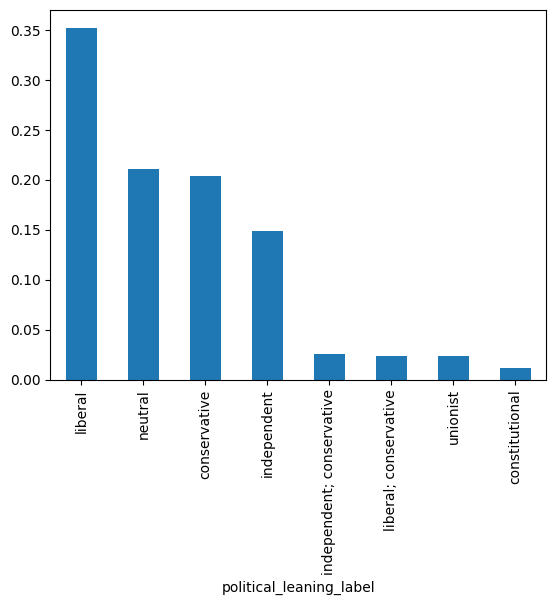

In [ ]:
column = 'political_leaning_label'
df[column].value_counts(normalize=True).plot(kind='bar')

In [ ]:
import re
pattern = re.compile(r'\btime[s]{0,1}\b',re.I)
df_kw_sample = df[df.apply(lambda x: bool(pattern.findall(x.text)), axis=1)]

prompt = """Read the newspaper article between triple ### attentively.
How does the article refer to the concept of 'time', for example using time indications or objects that measure time
"""
df_kw_sample['completion'] = df_kw_sample.progress_apply(generate_from_prompt, prompt=prompt, axis=1)
#df_kw_sample.to_csv('accidents.csv')

  0%|          | 0/30 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
  7%|▋         | 2/30 [00:18<04:24,  9.46s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 10%|█         | 3/30 [00:32<05:02, 11.20s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 13%|█▎        | 4/30 [00:42<04:39, 10.76s/it]The attention mask and the pad token id were not set. As a consequence, you may obs

In [ ]:
df_kw_sample['completion'].iloc[26]

' The given text is a poem titled "The Hunt," and the concept of time is implicitly referred to through various descriptions and the flow of actions in the poem. The following time indications and objects that measure time can be found in the poem:\n\n1. "mornings sun"\n2. "the hounds and horsemen take their way"\n3. "a glorious day!"\n4. " harder, with beating heart"\n5. "lying prone"\n6. "they still pursue their beffled quest"\n\nThese descriptions indicate the passing of time, with the morning sun representing the beginning of the hunt and the hounds and horsemen setting out. The hare is described as being hard-pressed and frightened, beating its heart and trying to fly, which also implies the passing of time. The use of words like "lost," "gone every trace," and "poor puss in peace" further suggests that time has passed since the hunt pursued the hare and eventually lost its scent.\n\nAdditionally, the description "Safe sheltered in her reedy nest" implies a sense of stillness and 